# IMPORTING THE LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# IMPORTING THE DATASET

In [18]:
df_train = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
df_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')

In [19]:
df_train.columns , df_test.columns

(Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
        'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
        'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
        'merch_lat', 'merch_long', 'is_fraud'],
       dtype='object'),
 Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
        'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
        'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
        'merch_lat', 'merch_long', 'is_fraud'],
       dtype='object'))

In [20]:
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [21]:
df_train.shape

(555719, 23)

DROPPING IRRELEVANT COLUMNS

In [22]:
df_train.drop(columns=[df_train.columns[0], 'cc_num', 'first', 'last', 'street',  'trans_num'], inplace=True)

In [23]:
df_train.columns , df_train.shape

(Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
        'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
        'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
       dtype='object'),
 (555719, 17))

In [24]:
# total number of fraud transaction
df_train[df_train['is_fraud']==1][['is_fraud']].count()

is_fraud    2145
dtype: int64

In [25]:
#total number of legit transaction
df_train[df_train['is_fraud']==0][['is_fraud']].count()

is_fraud    553574
dtype: int64

THE DATASET IS IMBALANCED

In [26]:
df_train.sample(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
160992,2020-08-16 22:46:29,"fraud_Hettinger, McCullough and Fay",home,10.42,F,North Washington,PA,16048,41.0472,-79.8089,139,Patent attorney,1954-05-25,1376693189,40.948704,-79.871014,0
339149,2020-10-29 16:12:28,fraud_Satterfield-Lowe,travel,2.06,F,North Loup,NE,68859,41.4972,-98.7858,509,"Nurse, children's",1980-09-15,1383063148,42.426026,-98.018296,0


CHECKING FOR MISSING VALUES

In [27]:
df_train.isnull().sum()

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
gender                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

> THERE ARE NO MISSING VALUES IN THE DATASET

# FEATURE ENGINEERING

ACCORDING TO THE DATASET, SINCE WE HAVE THE LOCATION DETAILS, WE CAN CALCULATE THE DISTANCE BETWEEN THE MERCHENT AND THE CUSTOMER 

In [28]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [29]:
df_train["distance"] = df_train.apply(lambda row: haversine_distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

In [30]:
# NOW WE CAN REMOVE THE LATITUDE AND LONGITUDE COLUMNS
df_train.drop(columns = ["lat", "long", "merch_lat", "merch_long"], inplace = True)

SINCE THE DATE OF BIRTH IS GIVEN , WE CAN CALCULATE THE AGES

In [32]:
df_train["dob"].dtype

dtype('O')

In [33]:
# Extracting the transaction year
df_train["trans_year"] = pd.Series(pd.to_datetime(df_train.trans_date_trans_time)).dt.year

# Finding the birth year of each person
df_train["dob"] = pd.Series(pd.to_datetime(df_train.dob)).dt.year

In [34]:
df_train.sample(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,city_pop,job,dob,unix_time,is_fraud,distance,trans_year
68102,2020-07-14 14:21:17,fraud_Bode-Schuster,kids_pets,92.94,M,Hancock,MD,21750,3766,Press photographer,1984,1373811677,0,47.329153,2020
532061,2020-12-27 03:22:21,"fraud_Olson, Becker and Koch",gas_transport,42.78,M,Alton,IA,51003,1700,"Engineer, land",2001,1388114541,0,19.486230,2020


In [35]:
# Calculating the age of each person and adding to train_data
age = pd.Series(df_train.trans_year - df_train.dob)
df_train["age"] = age

In [36]:
df_train.sample(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,city_pop,job,dob,unix_time,is_fraud,distance,trans_year,age
508355,2020-12-21 13:53:51,"fraud_Dare, Casper and Bartoletti",kids_pets,91.52,M,Pueblo,CO,81005,151815,Further education lecturer,1988,1387634031,0,101.236704,2020,32
207045,2020-09-01 16:25:21,fraud_Morissette PLC,shopping_pos,2.24,F,Plymouth,CT,6782,2376,Herpetologist,1973,1378052721,0,45.377395,2020,47


In [37]:
# Dividing individuals into age_groups
bins = [10, 18, 35, 60, 100]
labels = ["14-18", "18-35", "35-60", "60+"]
df_train["age_group"] = pd.cut(df_train['age'], bins=bins, labels=labels, right=True)

In [38]:
# Dropping age, trans_year and dob columns
df_train.drop(axis=1, columns=["age", "dob", "trans_year"], inplace=True)

LET'S EXTRACT SOME DATETIME INFO FROM TRANS_DATE_TRANS_TIME COLUMN

In [39]:
df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])

In [40]:
def day_period(x):
    if x >=0 and x < 6: return "Night"
    elif x>= 6 and x <= 12: return "Morning"
    elif x> 12 and x <= 15: return "Afternoon"
    elif x> 15 and x <= 20: return "Evening"
    elif x> 20 and x <= 24: return "Night"


df_train['day_period'] = df_train["trans_date_trans_time"].dt.hour.apply(day_period)

In [41]:
df_train.drop(columns = ["trans_date_trans_time"], inplace = True)

In [42]:
df_train.sample(5)

,merchant,category,amt,gender,city,state,zip,city_pop,job,unix_time,is_fraud,distance,age_group,day_period
67005,"fraud_Schaefer, McGlynn and Bosco",gas_transport,80.46,M,Harrodsburg,IN,47434,76,Social researcher,1373784688,0,56.200268,60+,Morning
275411,fraud_Hirthe-Beier,health_fitness,74.64,M,Pointe Aux Pins,MI,49775,95,Electrical engineer,1380651441,0,29.713029,18-35,Evening
292594,fraud_Ruecker-Mayert,kids_pets,17.71,F,Breesport,NY,14816,520,Psychotherapist,1381320141,0,58.922621,18-35,Morning
344113,fraud_Hamill-Daugherty,misc_net,11.61,F,Grover,NC,28073,5621,Toxicologist,1383288677,0,76.347192,35-60,Morning
32764,fraud_Flatley Group,misc_pos,3.05,M,Boonton,NJ,7005,15269,"Psychologist, sport and exercise",1372767671,0,91.275126,18-35,Morning


LET'S EXTRACT SOME JOBS SECTOR INFO

In [43]:
df_train['job'].unique() , df_train['job'].nunique()

(array(['Mechanical engineer', 'Sales professional, IT',
        'Librarian, public', 'Set designer', 'Furniture designer',
        'Psychotherapist', 'Therapist, occupational',
        'Development worker, international aid', 'Advice worker',
        'Barrister', 'Pensions consultant', 'Freight forwarder',
        'Paramedic', 'Building surveyor', 'Materials engineer',
        'Commercial horticulturist', 'Town planner',
        'Radiographer, therapeutic', 'Surveyor, rural practice',
        'Energy manager', 'Prison officer',
        'Museum/gallery exhibitions officer', 'Media planner',
        'Seismic interpreter', 'Learning disability nurse',
        'Buyer, industrial', 'Scientific laboratory technician',
        'Counselling psychologist', 'Scientist, biomedical',
        'Audiological scientist', 'Stage manager',
        'Leisure centre manager', 'Community pharmacist', 'Risk analyst',
        'Clinical research associate', 'Librarian, academic',
        'Editor, magazine fea

In [44]:
sector_bag = {
    "IT": ["engineer", "developer", "programmer", "software", "IT", "technician", "architect", "system", "network", 
           "administrator", "data scientist", "cybersecurity", "web developer", "analyst", "database", "devops"],
    
    "Education": ["teacher", "professor", "educator", "trainer", "lecturer", "scientist", "Orthoptist", "tutor", 
                  "principal", "instructor", "counselor", "academic", "researcher", "dean", "school", "headmaster"],
    
    "Healthcare": ["doctor", "nurse", "medical", "therapist", "pharmacist", "health", "surgeon", "dentist", "clinician", 
                   "physician", "optometrist", "radiologist", "paramedic", "midwife", "veterinarian", "psychiatrist"],
    
    "Finance": ["analyst", "accountant", "auditor", "banker", "financial", "investment", "controller", "broker", 
                "consultant", "treasurer", "loan officer", "trader", "actuary", "economist", "portfolio", "credit"],
    
    "Marketing": ["manager", "executive", "specialist", "consultant", "advertising", "public relations", "strategist", 
                  "director", "coordinator", "brand", "SEO", "content", "digital", "market research", "social media", 
                  "copywriter"],
    
    "Manufacturing": ["operator", "mechanic", "assembler", "fabricator", "engineer", "technician", "welder", 
                      "planner", "quality", "machinist", "production", "inspector", "supervisor", "foreman", 
                      "toolmaker", "CNC"],
    
    "Retail": ["cashier", "salesperson", "store", "associate", "manager", "clerk", "shopkeeper", "merchandiser", 
               "assistant", "retail", "customer service", "sales", "inventory", "buyer", "stocker", "checkout"],
    
    "Legal": ["lawyer", "attorney", "paralegal", "judge", "legal", "solicitor", "notary", "clerk", "litigator", 
              "advocate", "barrister", "counsel", "magistrate", "prosecutor", "defense", "compliance"],
    
    "Hospitality": ["chef", "waiter", "bartender", "host", "manager", "receptionist", "housekeeper", "concierge", 
                    "caterer", "cook", "hotel", "tour guide", "event planner", "sous chef", "sommelier", "valet"],
    
    "Construction": ["builder", "carpenter", "electrician", "plumber", "architect", "project manager", "site manager", 
                     "surveyor", "foreman", "bricklayer", "roofer", "civil engineer", "construction", "contractor", 
                     "inspector", "draftsman"]
}

def assign_sector(x):
    for key in sector_bag:
        for role in sector_bag[key]:
            if x.find(role) != -1:
                return key
    return "Other"

Text(0.5, 1.0, 'different job sectors')

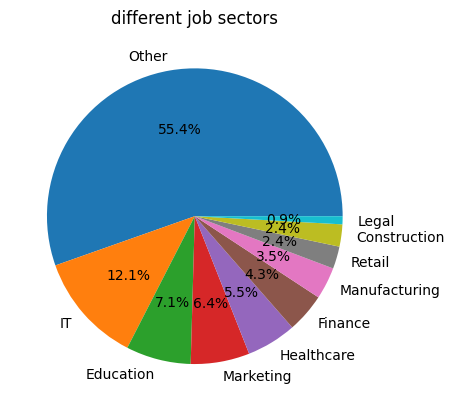

In [45]:
df_train["job_sector"] = df_train["job"].apply(assign_sector)
job = df_train["job_sector"].value_counts().reset_index()
plt.pie(x = job.get("count"), labels = job.get("job_sector"),autopct='%1.1f%%')
plt.title("different job sectors")

LET'S CONVERT THE STATE TO US REGIONS

In [46]:
state_to_region = {
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast',
    'MA': 'Northeast', 'RI': 'Northeast', 'CT': 'Northeast',
    'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'OH': 'Midwest', 'IN': 'Midwest', 'IL': 'Midwest', 'MI': 'Midwest',
    'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest',
    'DE': 'South', 'MD': 'South', 'DC': 'South', 'VA': 'South',
    'WV': 'South', 'NC': 'South', 'SC': 'South',
    'GA': 'South', 'FL': 'South', 'AL': 'South', 'MS': 'South',
    'TN': 'South', 'KY': 'South', 'AR': 'South', 'LA': 'South',
    'OK': 'South', 'TX': 'South', 'MT': 'Rocky Mountains', 'WY': 'Rocky Mountains',
    'CO': 'Rocky Mountains', 'NM': 'Rocky Mountains', 'ID': 'Rocky Mountains',
    'UT': 'Rocky Mountains', 'WA': 'Far West', 'OR': 'Far West',
    'CA': 'Far West', 'HI': 'Far West', 'AK': 'Far West'
}

df_train["Region"] = df_train.state.map(state_to_region)

REMOVING OTHER IRRELEVANT COLUMNS

In [49]:
df_train.drop(columns=['zip','city_pop','unix_time'], inplace=True)

# DATA VISUALISATION

In [50]:
df_train.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'job',
       'is_fraud', 'distance', 'age_group', 'day_period', 'job_sector',
       'Region'],
      dtype='object')

In [51]:
df_train.head(5)

,merchant,category,amt,gender,city,state,job,is_fraud,distance,age_group,day_period,job_sector,Region
0,fraud_Kirlin and Sons,personal_care,2.86,M,Columbia,SC,Mechanical engineer,0,24.561462,35-60,Morning,IT,South
1,fraud_Sporer-Keebler,personal_care,29.84,F,Altonah,UT,"Sales professional, IT",0,104.925092,18-35,Morning,IT,Rocky Mountains
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,Bellmore,NY,"Librarian, public",0,59.080078,35-60,Morning,Other,Northeast
3,fraud_Haley Group,misc_pos,60.05,M,Titusville,FL,Set designer,0,27.698567,18-35,Morning,Other,South
4,fraud_Johnston-Casper,travel,3.19,M,Falmouth,MI,Furniture designer,0,104.335106,60+,Morning,Other,Midwest


In [52]:
# Dividing train dataset into 2 sections - fraudulent and non-fraudulent

fraud = df_train[df_train.is_fraud == 1]
not_fraud = df_train[df_train.is_fraud == 0]

> BY CATEGORY

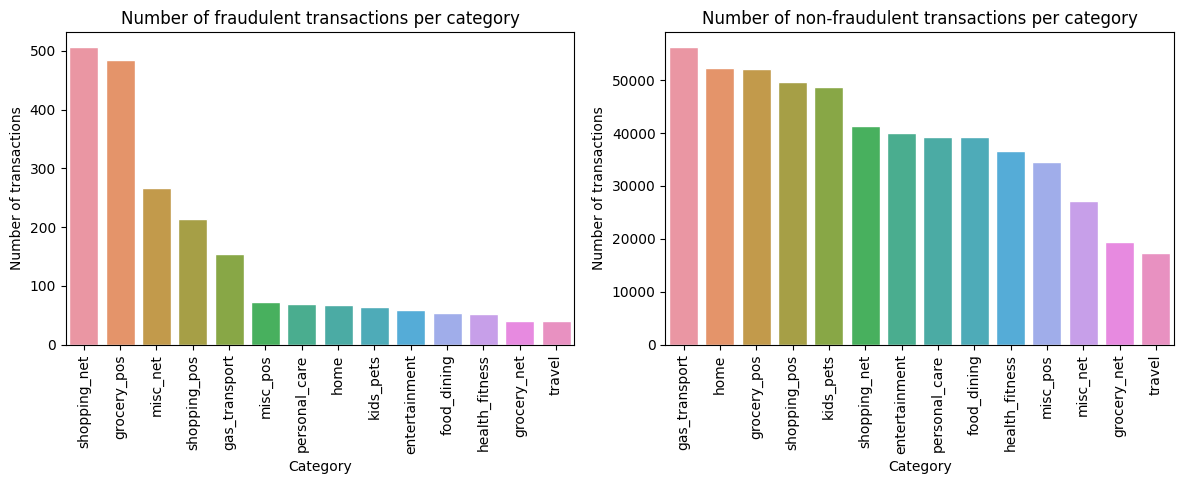

In [53]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Getting the counts of fraudulent and non-fraudulent activities per category
cat_fraud = fraud.category.value_counts().reset_index()
cat_fraud.columns = ["Category", "Counts"]
cat_not_fraud = not_fraud.category.value_counts().reset_index()
cat_not_fraud.columns = ["Category", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per category
sns.barplot(x="Category", y="Counts", data=cat_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Number of transactions")
axes[0].tick_params(axis="x", rotation=90)

sns.barplot(x="Category", y="Counts", data=cat_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Number of transactions")
axes[1].tick_params(axis="x", rotation=90)

plt.tight_layout()

> BY GENDER

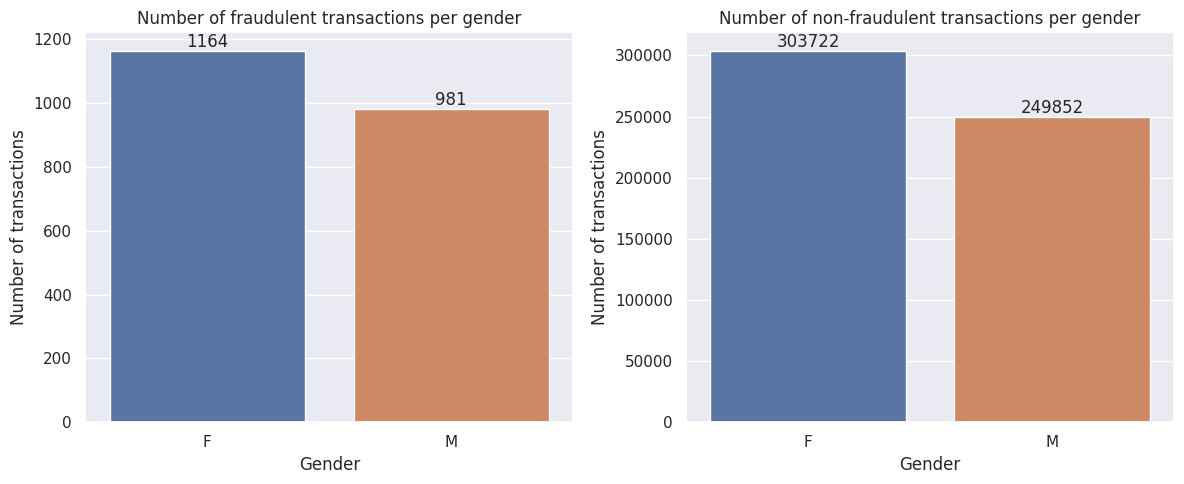

In [54]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Getting the counts of fraudulent and non-fraudulent activities per gender
g_fraud = fraud.gender.value_counts().reset_index()
g_fraud.columns = ["Gender", "Counts"]
g_not_fraud = not_fraud.gender.value_counts().reset_index()
g_not_fraud.columns = ["Gender", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Gender", y="Counts", data=g_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Gender", y="Counts", data=g_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

There is no significant difference in the proportion of fraud victims based on gender. However, women engage in a higher volume of transactions, with 709,863 recorded compared to 586,812 for men. Consequently, approximately 0.64% of transactions involving men are identified as fraudulent, whereas this figure is slightly lower for women, at 0.53%.

> BY AGE

In [55]:
# Extracting fraudulent and non-fraudulent transactions by age_group
age_fraud = df_train[df_train.is_fraud == 1].age_group.value_counts().reset_index()
age_fraud.columns = ["Age group", "Counts"]
age_not_fraud = df_train[df_train.is_fraud == 0].age_group.value_counts().reset_index()
age_not_fraud.columns = ["Age group", "Counts"]

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


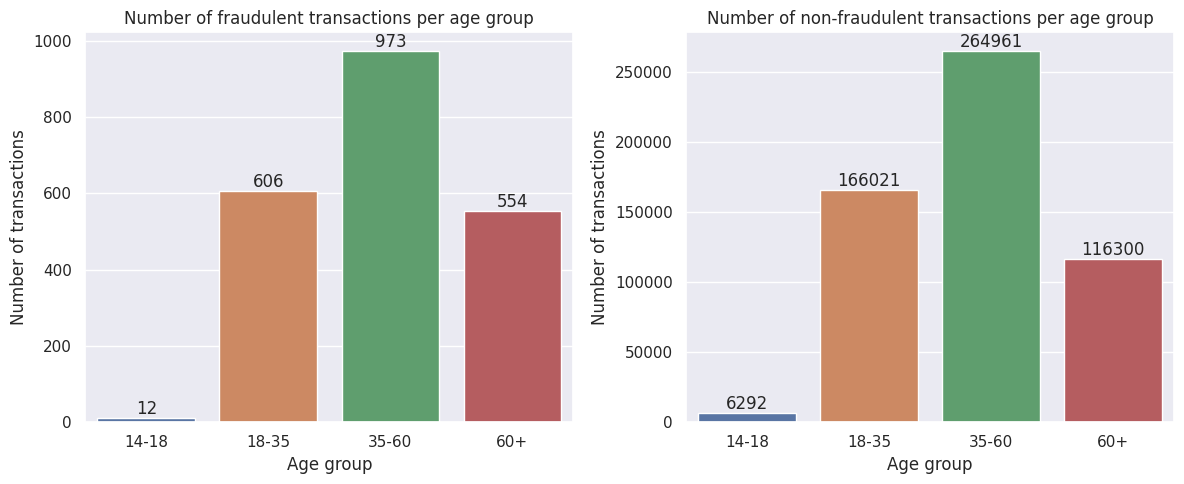

In [56]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Age group", y="Counts", data=age_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per age group")
axes[0].set_xlabel("Age group")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Age group", y="Counts", data=age_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per age group")
axes[1].set_xlabel("Age group")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

1. Teenagers are the least likely to become victims of credit card fraud, likely due to their limited access to credit cards compared to older age groups.

2. Middle-aged individuals are more vulnerable to credit card fraud, as indicated by the bar chart, which may be attributed to their higher frequency of credit card usage.

3. Fraudulent transactions are most prevalent among individuals aged 60 and above, with a rate of 0.75%, possibly linked to lower levels of digital literacy in this demographic.

> BY US REGION

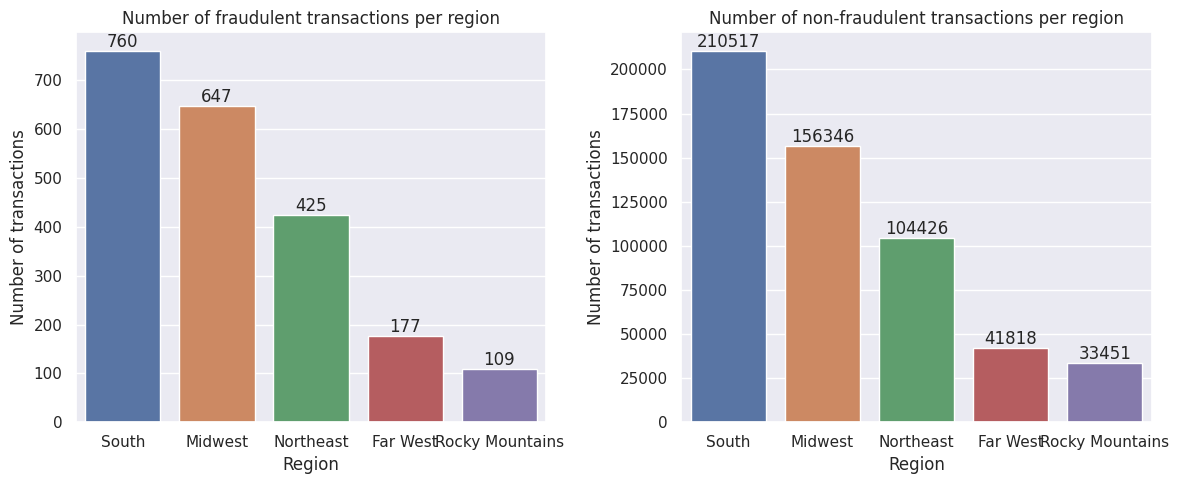

In [57]:
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Extracting fraudulent and non-fraudulent transactions by region
r_fraud = df_train[df_train.is_fraud == 1].Region.value_counts().reset_index()
r_fraud.columns = ["Region", "Counts"]
r_not_fraud =df_train[df_train.is_fraud == 0].Region.value_counts().reset_index()
r_not_fraud.columns = ["Region", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Region", y="Counts", data=r_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per region")
axes[0].set_xlabel("Region")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Region", y="Counts", data=r_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per region")
axes[1].set_xlabel("Region")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

> BY JOB SECTOR

Text(0.5, 1.0, 'different job sectors')

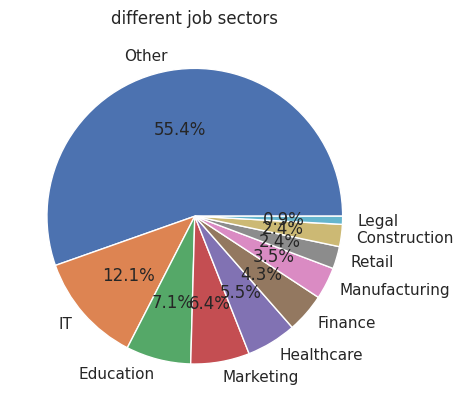

In [58]:
job = df_train["job_sector"].value_counts().reset_index()
plt.pie(x = job.get("count"), labels = job.get("job_sector"),autopct='%1.1f%%')
plt.title("different job sectors")

In [60]:
df_train.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'job',
       'is_fraud', 'distance', 'age_group', 'day_period', 'job_sector',
       'Region'],
      dtype='object')

# UNIVARIATE ANALYSIS ON CATEGORICAL DATA

1. From the above columns, my categorical data are : category, gender, is_fraud, Region, job_sector, age_group and day_period
2. And my numerical data are : amt , distance

DROPPING REST OF THE COLUMNS

In [61]:
df_train.drop(columns=['merchant','city','state','job'],inplace=True)

In [62]:
df_train.columns

Index(['category', 'amt', 'gender', 'is_fraud', 'distance', 'age_group',
       'day_period', 'job_sector', 'Region'],
      dtype='object')

In [75]:
categorical = ['category','gender','Region','job_sector','age_group','day_period']

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


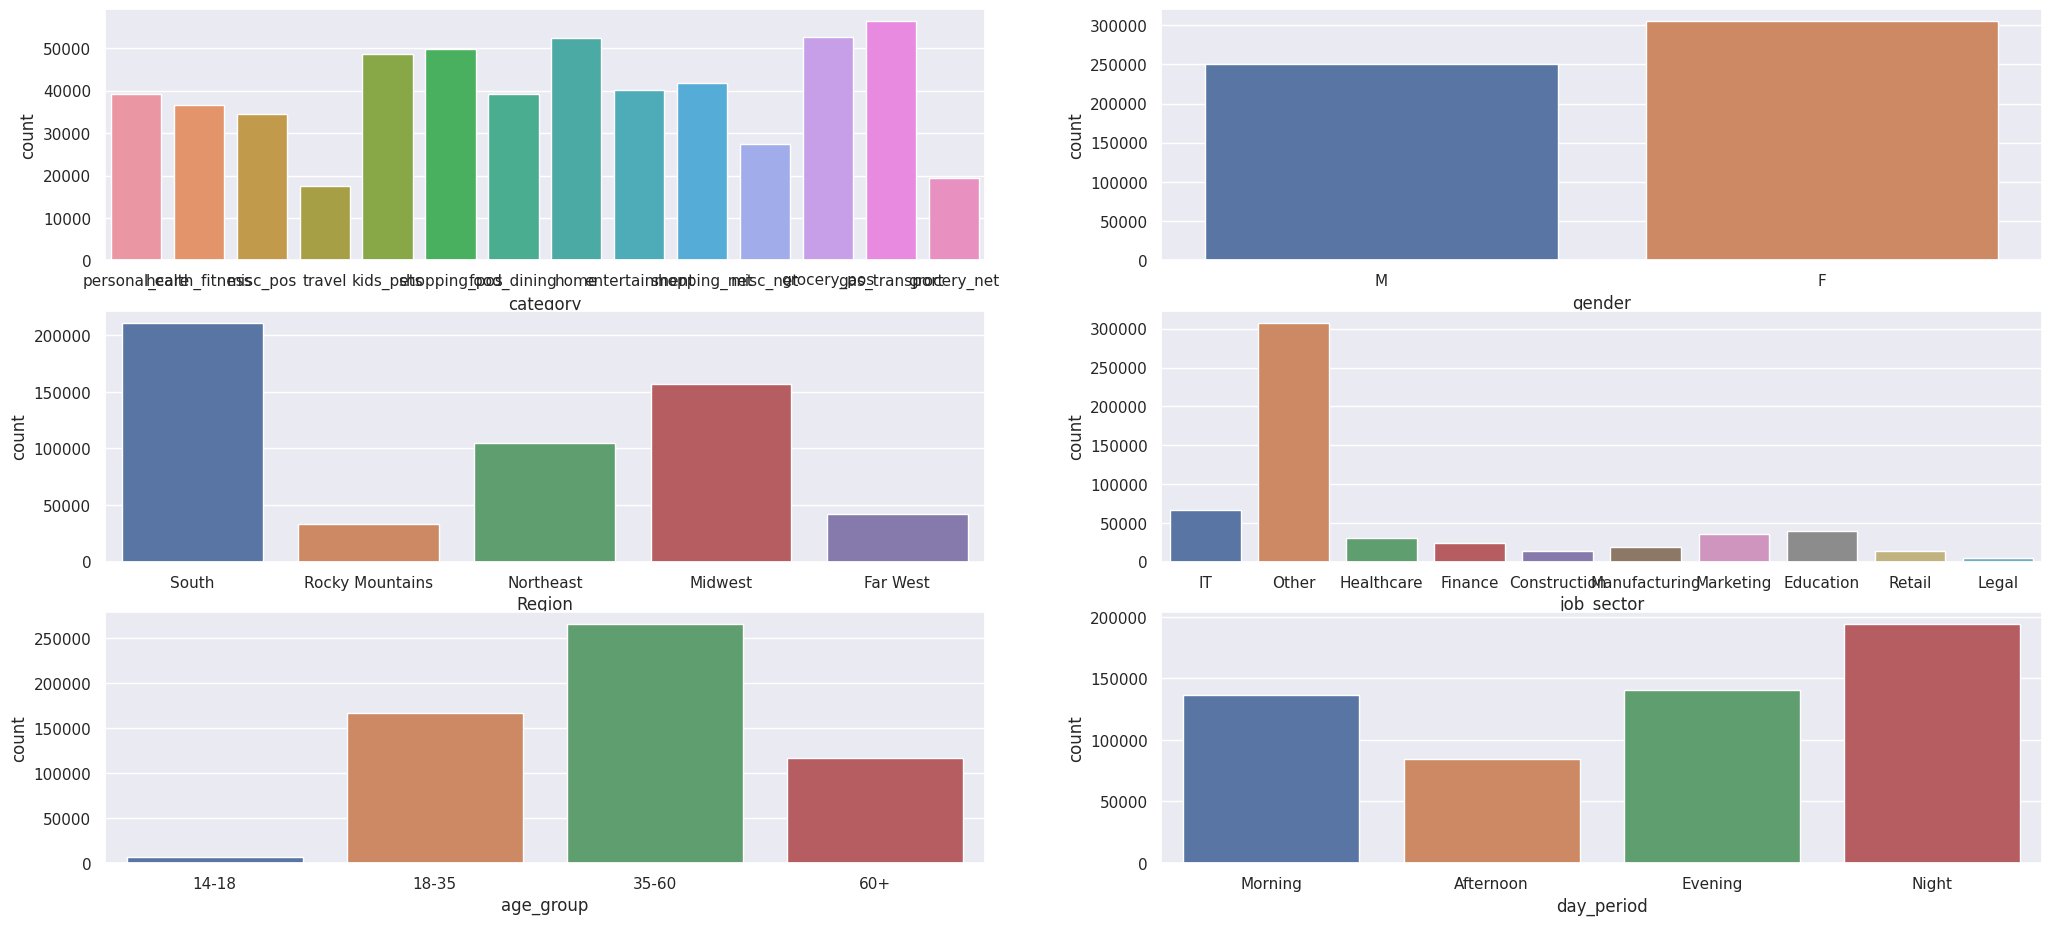

In [76]:
plt.figure(figsize = (25, 15))
cnt = 0
for column in categorical:
    cnt += 1
    plt.subplot(4, 2, cnt)
    sns.countplot(x = df_train[column])

OBSERVATIONS :
* Female count is more in data.
* Weekend days are almost half of no weekend days.
* Lot of transaction happened at Night
* Middle-aged individuals are more vulnerable to credit card fraud, as indicated by the bar chart, which may be attributed to their higher frequency of credit card usage.

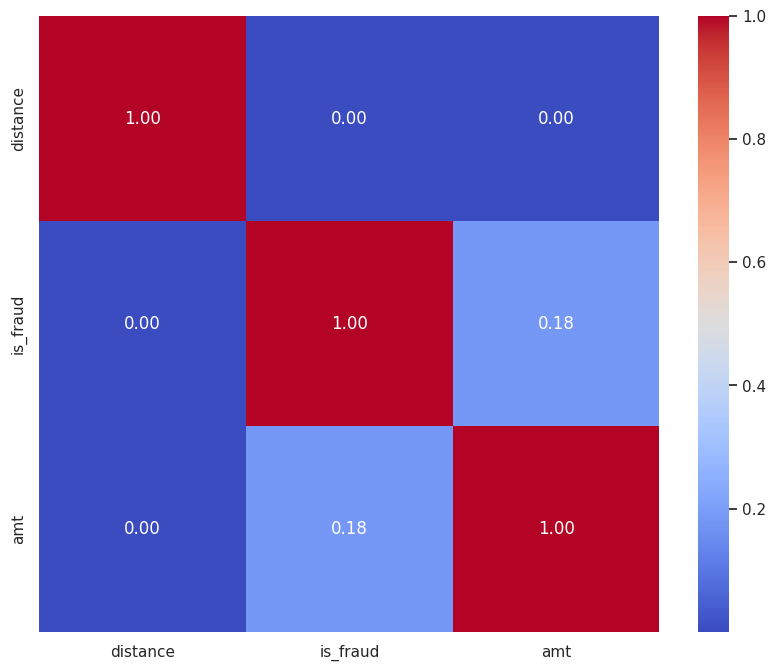

In [72]:
numerical_col = ['distance','is_fraud','amt']
correlation_matrix = df_train[numerical_col].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.show()

SINCE BOTH NUMERICAL FEATURES HAVE SAME CORRELATION WITH THE TARGET COLUMN, WE CAN DROP ONE.

In [77]:
df_train.drop(columns=['distance','job_sector'],inplace=True)

In [78]:
df_train.columns

Index(['category', 'amt', 'gender', 'is_fraud', 'age_group', 'day_period',
       'Region'],
      dtype='object')

In [79]:
df_train.head(5)

,category,amt,gender,is_fraud,age_group,day_period,Region
0,personal_care,2.86,M,0,35-60,Morning,South
1,personal_care,29.84,F,0,18-35,Morning,Rocky Mountains
2,health_fitness,41.28,F,0,35-60,Morning,Northeast
3,misc_pos,60.05,M,0,18-35,Morning,South
4,travel,3.19,M,0,60+,Morning,Midwest


# MODELLING USING RANDOM FOREST

> PREPARING DATA FOR MODELLING BY USING ONE HOT ENCODING

In [81]:
train_data = pd.get_dummies(df_train, columns = ["category", "gender", "Region", "age_group", "day_period"], drop_first=True)

In [82]:
train_data.columns

Index(['amt', 'is_fraud', 'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'Region_Midwest', 'Region_Northeast',
       'Region_Rocky Mountains', 'Region_South', 'age_group_18-35',
       'age_group_35-60', 'age_group_60+', 'day_period_Evening',
       'day_period_Morning', 'day_period_Night'],
      dtype='object')

> IDENTIFYING LABELS AND FEATURES

In [83]:
features = train_data.drop(axis=1, columns=["is_fraud"], inplace=False)
label = train_data["is_fraud"]

> IMPORTING RELEVANT LIBRARIES, FUCNTIONS

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(features, label)

RandomForestClassifier(class_weight='balanced', random_state=42)

# IMPORTING AND PREPARING THE TEST DATA

In [104]:
# Importing test dataset
test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

In [105]:
test.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [106]:
# Dropping redundant columns
test.drop(axis=1, columns=["Unnamed: 0", "cc_num", "merchant", "first", "last", "street", "city", "zip", "lat", "long", "city_pop", "job", "trans_num", "unix_time", "merch_lat", "merch_long"], inplace=True)

In [107]:
# Adding "Region" column to test data
test["Region"] = test.state.map(state_to_region)

In [109]:
# Adding age group column 
test["trans_year"] = pd.Series(pd.to_datetime(test.trans_date_trans_time)).dt.year
test["dob"] = pd.Series(pd.to_datetime(test.dob)).dt.year

age = pd.Series(test.trans_year - test.dob)
test["age"] = age

bins = [10, 18, 35, 60, 100]
labels = ["14-18", "18-35", "35-60", "60+"]
test["age_group"] = pd.cut(test['age'], bins=bins, labels=labels, right=True)

In [110]:
# Adding the day_period column
test["trans_date_trans_time"] = pd.to_datetime(test["trans_date_trans_time"])
test['day_period'] = test['trans_date_trans_time'].dt.hour.apply(day_period)

In [111]:
test.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'dob',
       'is_fraud', 'Region', 'trans_year', 'age', 'age_group', 'day_period'],
      dtype='object')

In [112]:
# Dropping all remaining redundant columns
test.drop(axis=1, columns=["dob", "trans_year", "trans_date_trans_time", "age", "state"], inplace=True)

In [113]:
test.columns

Index(['category', 'amt', 'gender', 'is_fraud', 'Region', 'age_group',
       'day_period'],
      dtype='object')

In [114]:
# One hot encoding
test = pd.get_dummies(test, columns = ["category", "gender", "Region", "age_group", "day_period"], drop_first=True)

In [115]:
test.columns

Index(['amt', 'is_fraud', 'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'Region_Midwest', 'Region_Northeast',
       'Region_Rocky Mountains', 'Region_South', 'age_group_18-35',
       'age_group_35-60', 'age_group_60+', 'day_period_Evening',
       'day_period_Morning', 'day_period_Night'],
      dtype='object')

In [116]:
# Extracting features and label from test data
test_f = test.drop(axis=1, columns=["is_fraud"], inplace=False)
test_l = test["is_fraud"]

# EVALUATING THE MODEL

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [117]:
rf_pred = rf.predict(test_f)

> CALCULATING ACCURACY

In [120]:
accuracy = accuracy_score(test_l, rf_pred)
accuracy

0.9999514142939148

> CONFUSION MATRIX

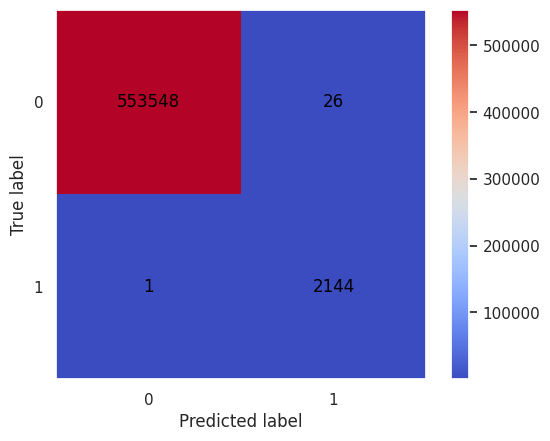

In [121]:
rf_cm = confusion_matrix(test_l, rf_pred)
rf_mat = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_)
rf_mat.plot(cmap="coolwarm")
for text in rf_mat.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

> The Random Forest model is far superior to the other algorithms both in terms of accuracy and its handling of the class imbalance by minimising the number of false negatives and false positives.

# SAVING THE MODEL

In [123]:
import joblib

joblib.dump(rf, 'RF_model.pkl')


['RF_model.pkl']

# TRAINING USING LOGISTIC REGRESSION USING CLASS WEIGHTS

In [124]:
from sklearn.linear_model import LogisticRegression

In [125]:
lr = LogisticRegression(penalty="l2", fit_intercept=False, random_state=42, class_weight="balanced")
lr.fit(features, label)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', fit_intercept=False,
                   random_state=42)

In [126]:
pred2 = lr.predict(test_f)
accuracy2 = accuracy_score(test_l, pred2)
accuracy2

0.8476478220107644

We have a much lower accuracy than RandomForest classifier

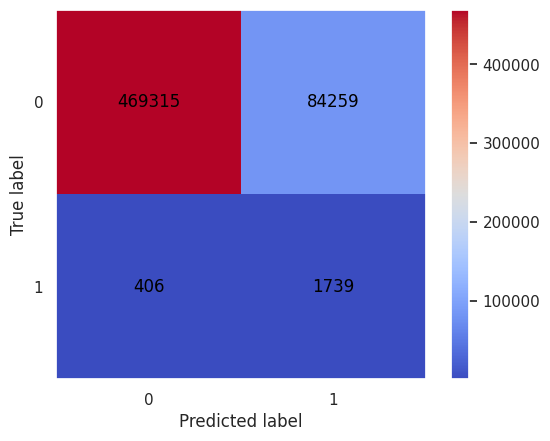

In [128]:
cm2 = confusion_matrix(test_l, pred2)
matrix2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=lr.classes_)
matrix2.plot(cmap="coolwarm")
for text in matrix2.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

# MY MOST REDUNDANT FEATURES ACCORDING TO RANDOM FOREST

Text(0.5, 0, 'Feature Importance')

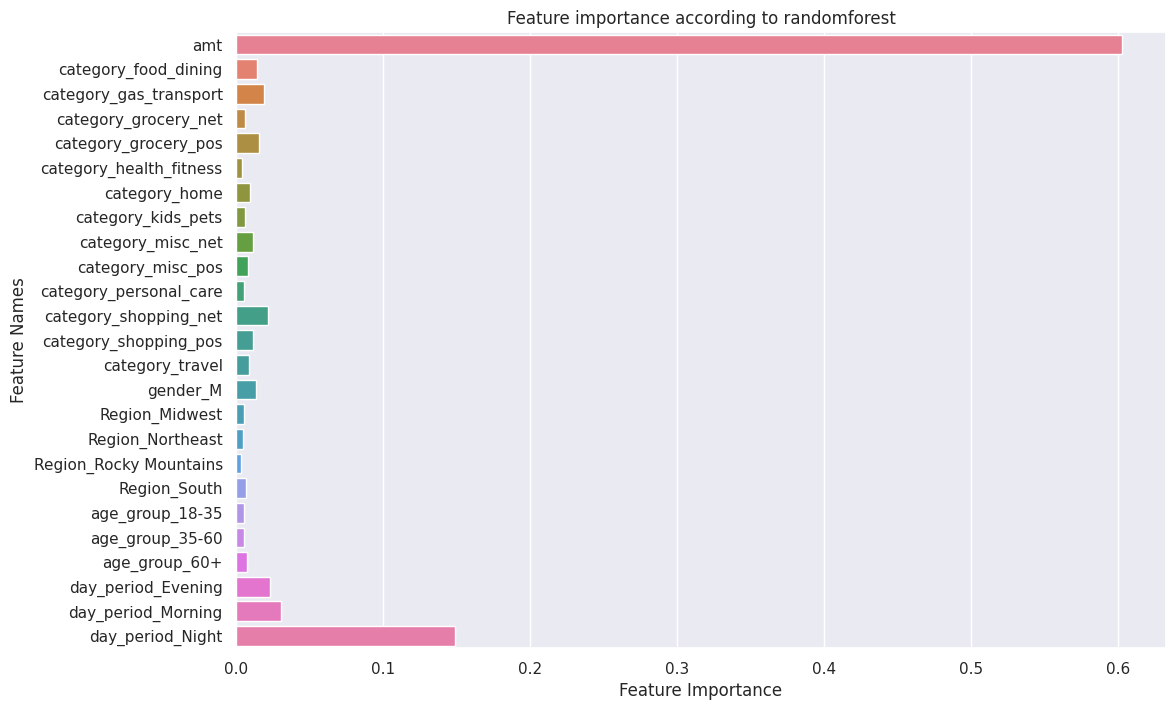

In [131]:
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(rf.feature_importances_))  # "husl" is just one example palette
sns.barplot(x = rf.feature_importances_, y = train_data.drop(columns = ["is_fraud"]).columns, palette=colors)
plt.title("Feature importance according to randomforest")
plt.ylabel("Feature Names")
plt.xlabel("Feature Importance")